In [10]:
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.nn.functional as F
from torchsummary import summary
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
data = pd.read_csv('./FER_data.csv')

In [17]:
pixels = data['pixels'].values
emotions = data['emotion'].values
usage = data['usage'].values

X = np.array([np.fromstring(pixel, sep=' ') for pixel in pixels], dtype=np.float32)
X = X.reshape(-1, 48, 48, 1)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(emotions)

X_test = X[usage == 'PublicTest']
y_test = y[usage == 'PublicTest']

In [ ]:
X_test = X[usage == 'PrivateTest']
y_test = y[usage == 'PrivateTest']

In [18]:
class FERDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels.astype(np.int64)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)

        return image, label

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_dataset = FERDataset(X_test, y_test, transform=test_transform)

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [19]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.25)
        
        self.conv5 = nn.Conv2d(128, 256, kernel_size=5, padding=2)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout(0.25)

        self.fc1 = nn.Linear(256 * 6 * 6, 1024)
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 10)
        
    def forward(self, x):
    
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.bn1(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.bn2(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        x = F.relu(self.conv5(x))
        x= self.bn3(x)
        x = self.pool3(x)
        x= self.dropout3(x)
        
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout4(x)
        x = self.fc2(x)
        
        return x

model = CNNModel()
model.load_state_dict(torch.load('./FER_model.pth'))

<All keys matched successfully>

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()

correct_test = 0
total_test = 0
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)  # Get the predicted class
        
        total_test += labels.size(0)  # Increment total number of samples
        correct_test += (predicted == labels).sum().item()  # Increment correct predictions
        
        all_labels.extend(labels.cpu().numpy())  # Store all true labels
        all_predictions.extend(predicted.cpu().numpy())  # Store all predictions

# Calculate accuracy，precision, recall, and F1 score
test_accuracy = 100 * correct_test / total_test
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')
print(f'Test Accuracy: {test_accuracy:.2f}%')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')


Test Accuracy: 77.71%
Precision: 0.77
Recall: 0.78
F1 Score: 0.77


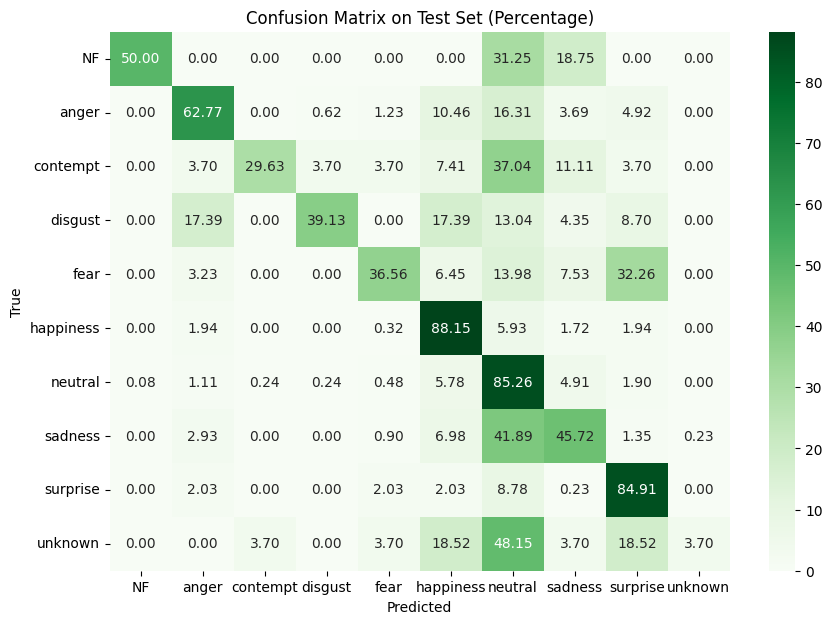

In [17]:
cm = confusion_matrix(all_labels, all_predictions)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
class_names = label_encoder.classes_
plt.figure(figsize=(10, 7))
sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Test Set (Percentage)')
plt.show()